# Wiggly boundary simulation setup

In [1]:
using LaTeXStrings
using GaussianProcesses
import GeoInterface
using Distributions
# using Base.LinAlg
using LibGEOS
using Distances
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
module GeoRDD
    using GaussianProcesses
    using PDMats
    include("src/geometry.jl")
    include("src/cliff_face.jl")
    include("src/point_estimates.jl")
    include("src/border_projection.jl")
end

GeoRDD

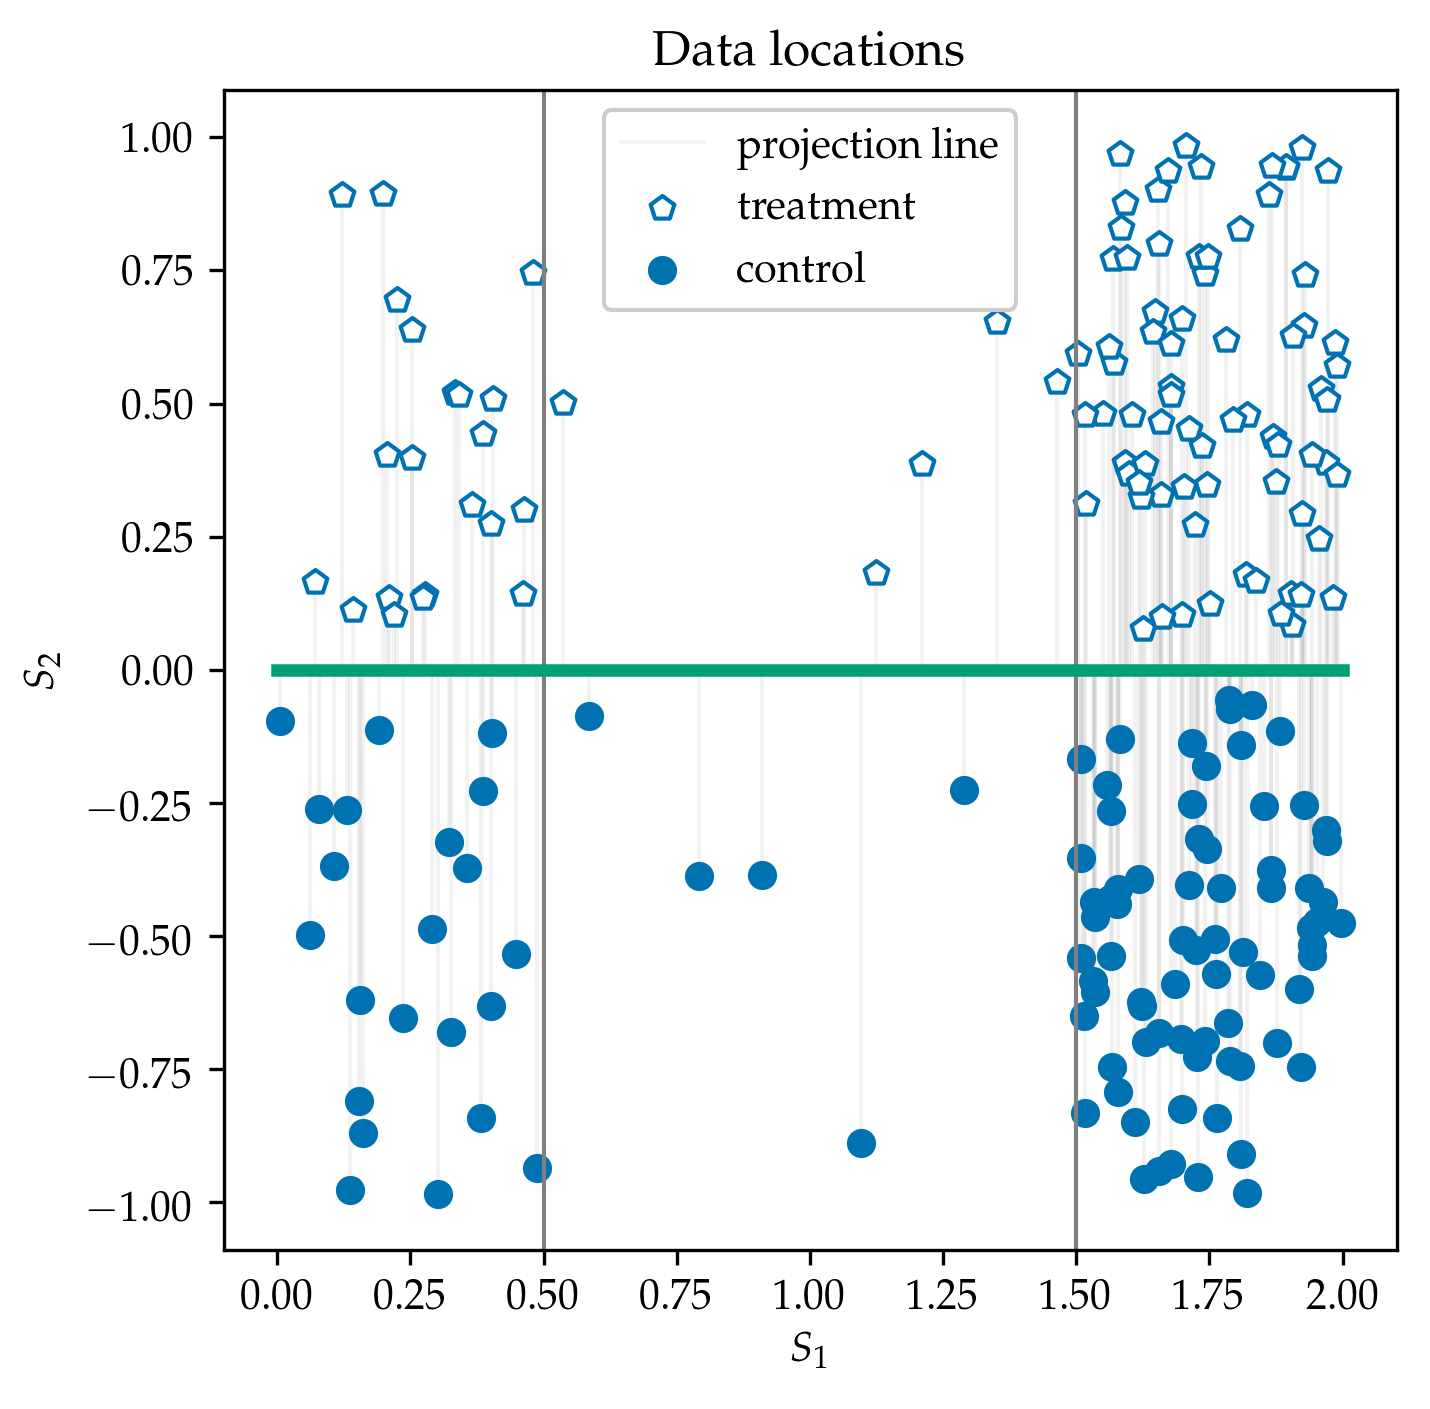

In [3]:
function border_line(numwiggles::Integer, A::Number)
    @assert numwiggles >= 0
    if numwiggles == 0
        line = [[0.0,0.0], [2.0,0.0]]
        return LineString(line)
    end
        
    x_left = collect(linspace(0, 0.5, numwiggles*4+1))
    y_left = repeat([0.0, A/2, 0.0, -A/2], outer=numwiggles)
    x = [x_left; 2.0]
    y = [y_left; 0.0; 0.0]
    @assert length(x) == length(y)
    
    line = [[xi, yi] for (xi,yi) in zip(x,y)]
    return LineString(line)
end
# define boundary:
# below 0.5: triangular wave
# above 0.5: straight line
bins = [0.0, 0.5, 1.5, 2.0]
densities = [1.0, 0.1, 2.8]
# τtrue     = [0.2, 1.0, 2.0]

function wb_density(x)
    if x < bins[2]
        return densities[1]
    elseif x < bins[3]
        return densities[2]
    else
        return densities[3]
    end
end

# define treatment effect 
function wb_τx(x)
    return x
end
wb_A = 0.1
pw = diff(bins).*densities
X1distr = MixtureModel(
    [Uniform(bins[i],bins[i+1]) for i in 1:length(densities)],
    Categorical(pw ./ sum(pw))
    )
X2distr_treat = Uniform(wb_A/2, 1.0)
X2distr_ctrol = Uniform(-1.0, -wb_A/2)
wb_nwiggles = 0
wb_n = 200
wb_ntreat = 100
wb_nctrol = wb_n-wb_ntreat
wbX_treat = [rand(X1distr, wb_ntreat)'; 
             rand(X2distr_treat, wb_ntreat)']
wbX_ctrol = [rand(X1distr, wb_nctrol)'; 
             rand(X2distr_ctrol, wb_nctrol)']

wb_border = border_line(wb_nwiggles, wb_A)
border_points = [interpolate(wb_border,q) for q in linspace(0,geomLength(wb_border),1000)]
border_coords = [GeoInterface.coordinates(p) for p in border_points]
border_x = [p[1] for p in border_coords]
border_y = [p[2] for p in border_coords]


function plot_setup()
    plt.axvline(0.5, color="grey", linewidth=1)
    plt.axvline(1.5, color="grey", linewidth=1)
    for itreat in 1:wb_ntreat
        # obtain coordinates for treatment point
        x,y = wbX_treat[:,itreat]
        # projection onto border (as distance along border)
        proj_point = nearestPoints(wb_border, Point(x,y))[1]
#         proj_dist = project(wb_border, Point(x,y))
        # get border point from distance
#         proj_point = interpolate(wb_border, proj_dist)
        # get coordinates from point
        proj_x, proj_y = GeoInterface.coordinates(proj_point)
        if itreat==1
            label="projection line"
        else
            label=""
        end
        plt.plot([x, proj_x], [y, proj_y], 
                color="black", alpha=0.05, linewidth=1,
                label=label,
                zorder=-10)
    end
    for ictrol in 1:wb_nctrol
        # obtain coordinates for treatment point
        x,y = wbX_ctrol[:,ictrol]
        # projection onto border (as distance along border)
#         proj_dist = project(wb_border, Point(x,y))
        proj_point = nearestPoints(wb_border, Point(x,y))[1]
        # get border point from distance
#         proj_point = interpolate(wb_border, proj_dist)
        # get coordinates from point
        proj_x, proj_y = GeoInterface.coordinates(proj_point)
        plt.plot([x, proj_x], [y, proj_y], 
                color="black", alpha=0.05, linewidth=1,
                zorder=-10)
    end
    
    plt.scatter(wbX_treat[1,:],wbX_treat[2,:], color="white", edgecolor="#0072B2", marker="p", label="treatment")
    plt.scatter(wbX_ctrol[1,:],wbX_ctrol[2,:], color="#0072B2", label="control")
    ax = plt.gca()
    ax[:set_aspect]("equal")
    plt.plot(border_x, border_y, linewidth=3, color="#009E73")
    plt.grid(false)
    plt.title("Data locations")
    plt.legend(loc="best", framealpha=1.0)
    plt.xlabel(L"$S_1$")
    plt.ylabel(L"$S_2$")
end
plot_setup()
;

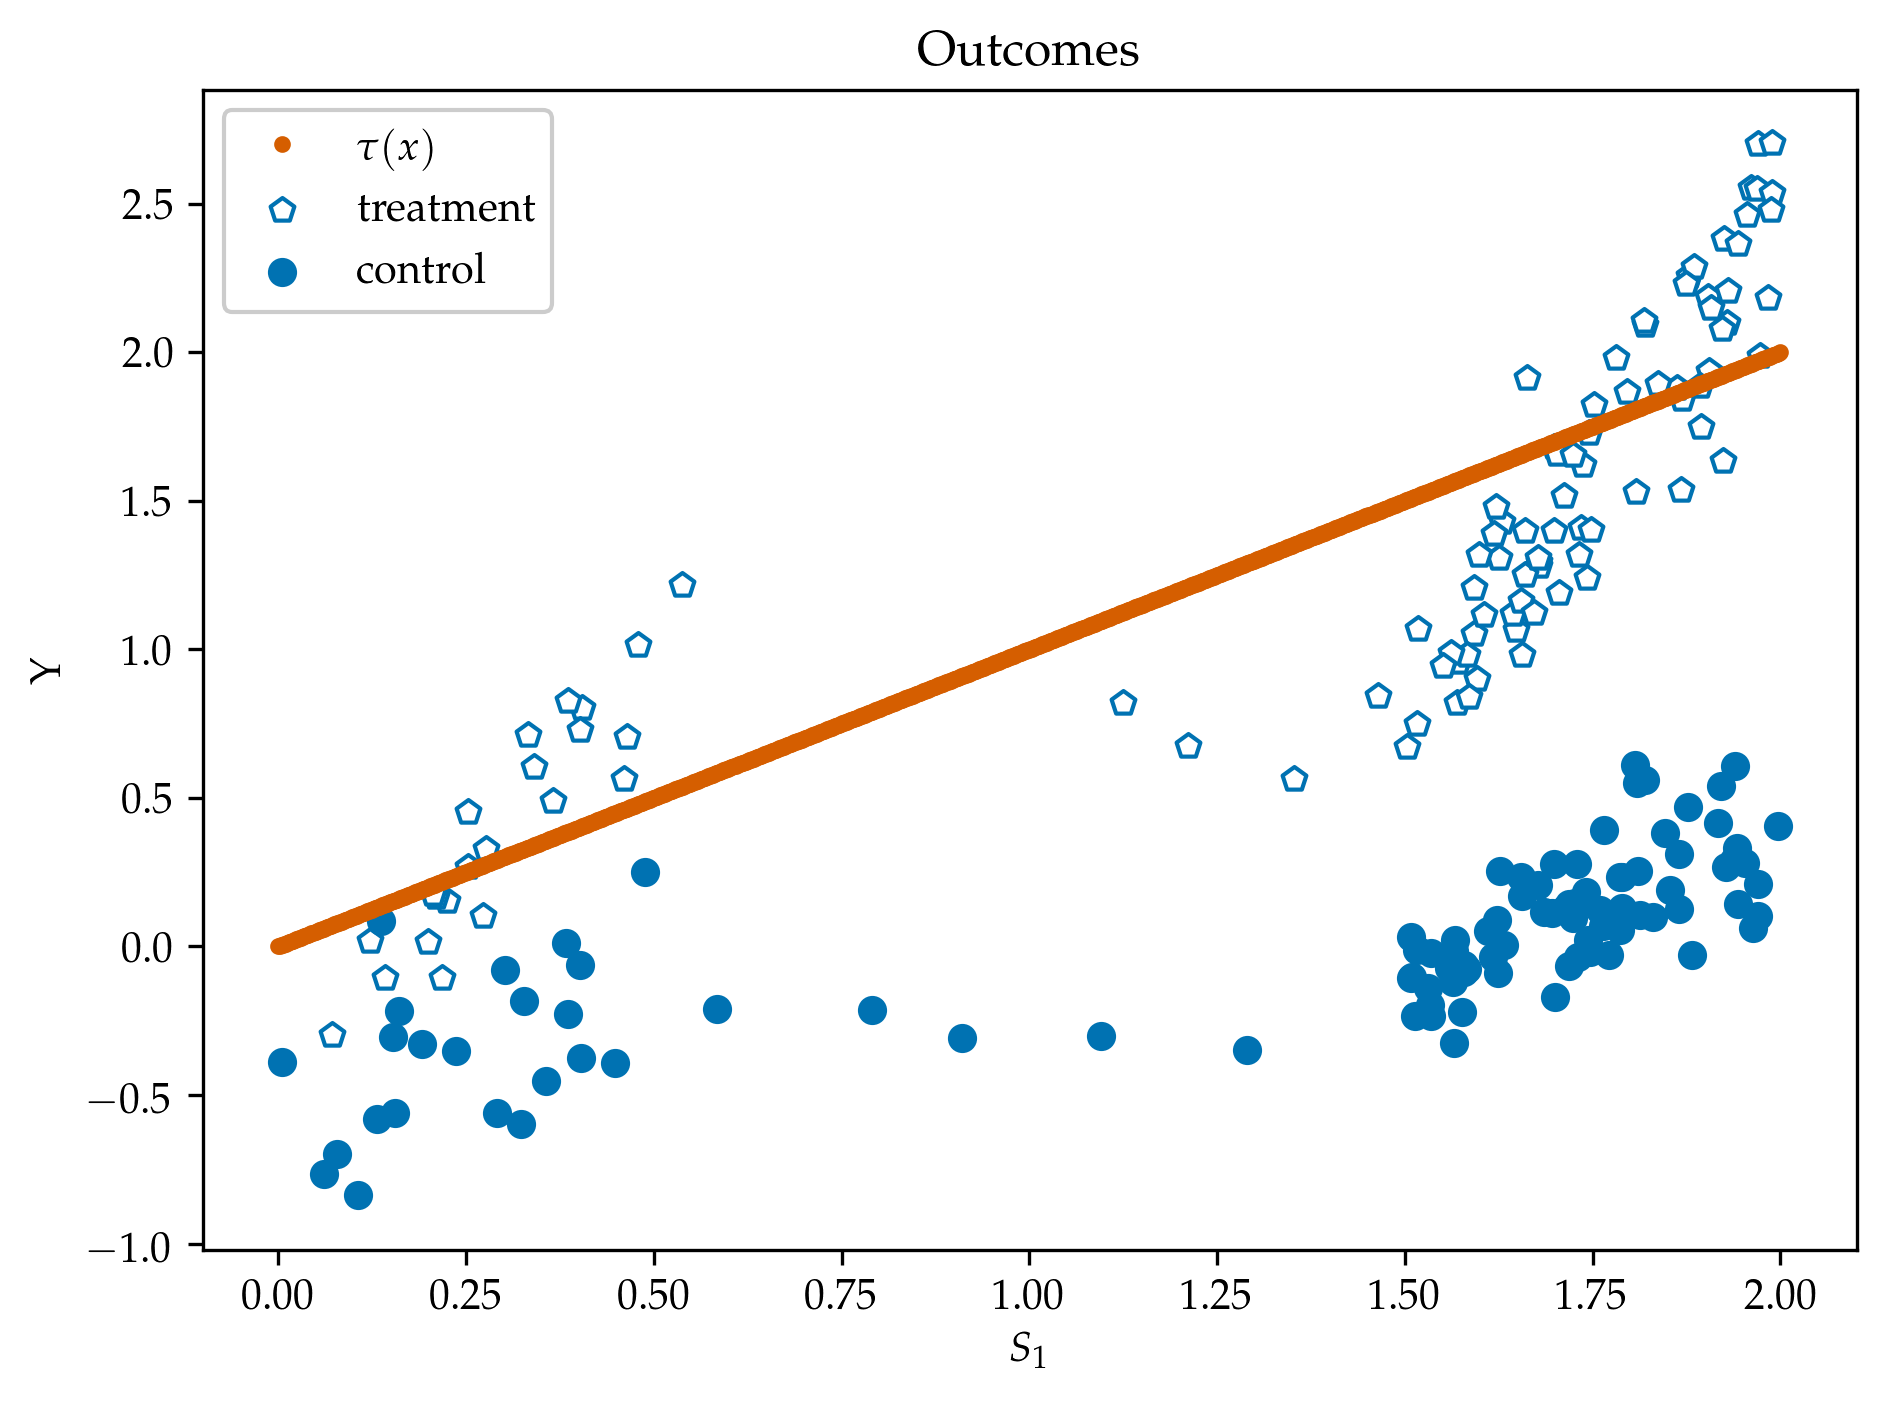

In [4]:
wb_kern = SE(log(0.4), log(0.5))
wb_Σprior=GaussianProcesses.cov(wb_kern, [wbX_treat wbX_ctrol])
wb_μprior=zeros(wb_n)
wb_Σobs=copy(wb_Σprior)
wb_σy2 = 0.1^2
for i in 1:wb_n
    wb_Σobs[i,i] += wb_σy2
end
wb_prior=MultivariateNormal(wb_μprior,wb_Σobs)
wb_Y=rand(wb_prior)
wb_treat = [ones(Bool,wb_ntreat);zeros(Bool,wb_nctrol)]
wb_Y[wb_treat] .+= [wb_τx(wbX_treat[1,i]) for i in 1:wb_ntreat] # apply treatment effect
function plot_outcomes()
    plt.scatter(vec(wbX_treat[1,:]), wb_Y[wb_treat], 
                color="white", 
                edgecolor="#0072B2", 
                marker="p", 
                label="treatment")
    plt.scatter(vec(wbX_ctrol[1,:]), wb_Y[.!wb_treat], 
                color="#0072B2", 
                label="control")
    plt.xlabel(L"S_1")
    plt.ylabel("Y")
    xx = linspace(0,2.0,1000)
    plt.plot(xx, wb_τx.(xx), ".", color="#D55E00", label=L"\tau(x)")
    plt.legend(loc="best", framealpha=1.0)
    plt.title("Outcomes")
end
plot_outcomes()
;

# Infinite projection estimator

In [5]:
wb_fit_treat = GP(wbX_treat, wb_Y[wb_treat],  
                  MeanConst(mean(wb_Y[wb_treat])), 
                  wb_kern, log(√wb_σy2))
wb_fit_ctrol = GP(wbX_ctrol, wb_Y[.!wb_treat], 
                  MeanConst(mean(wb_Y[.!wb_treat])), 
                  wb_kern, log(√wb_σy2))
;

In [44]:
gpT = wb_fit_treat
gpC = wb_fit_ctrol
border = wb_border
maxdist = 0.2
gridspace = 0.01
density = (s1,s2) -> 1.0

(::#64) (generic function with 1 method)

In [7]:
region = GeoRDD.data_hull(gpT, gpC)

LibGEOS.MultiPolygon(Ptr{Ptr{Void}} @0x00007fd6fc34fce8)

In [8]:
Profile.clear()
GeoRDD.infinite_proj_sentinels(gpT, gpC, border, region, maxdist, gridspace)
@time GeoRDD.infinite_proj_sentinels(gpT, gpC, border, region, maxdist, gridspace)
@profile GeoRDD.infinite_proj_sentinels(gpT, gpC, border, region, maxdist, gridspace)

  0.605360 seconds (805.33 k allocations: 34.935 MiB, 1.46% gc time)


([0.184814 0.864814 … 1.94481 1.88481; 0.0 0.0 … 0.0 0.0], [20.0, 23.0, 21.0, 24.0, 25.0, 20.0, 23.0, 23.0, 24.0, 23.0  …  26.0, 21.0, 10.0, 24.0, 20.0, 26.0, 23.0, 23.0, 9.0, 20.0])

In [9]:
region_C = LibGEOS.Polygon([
    [[0.0, -1.0],    # bottom left
     [0.0, -wb_A/2], # top left
     [2.0, -wb_A/2], # top right
     [2.0, -1.0],    # bottom right
     [0.0, -1.0]]])
region_T = LibGEOS.Polygon([
    [[0.0, 1.0],     # top left
     [0.0, wb_A/2],  # bottom left
     [2.0, wb_A/2],  # bottom right
     [2.0, 1.0],     # top right
     [0.0, 1.0]]])
region = LibGEOS.union(region_C, region_T)

LibGEOS.MultiPolygon(Ptr{Ptr{Void}} @0x00007fd6ff6f93c8)

In [10]:
Profile.clear()
GeoRDD.infinite_proj_sentinels(gpT, gpC, border, region, maxdist, gridspace)
@time GeoRDD.infinite_proj_sentinels(gpT, gpC, border, region, maxdist, gridspace)
@profile GeoRDD.infinite_proj_sentinels(gpT, gpC, border, region, maxdist, gridspace)

  0.644385 seconds (880.01 k allocations: 37.766 MiB, 2.86% gc time)


([1.12 1.81 … 0.97 0.51; 0.0 0.0 … 0.0 0.0], [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0  …  30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0])

# Using intersect

In [11]:
import GeoInterface: coordinates, xcoord, ycoord
import LibGEOS
import IterTools
import DataStructures
import LibGEOS: nearestPoints, interpolate, distance
import LibGEOS: MultiPolygon, envelope
import GaussianProcesses: GPE

import LibGEOS: LineString, MultiLineString
import GeoInterface

# type conversion
const BorderType = Union{MultiLineString, LineString}
BorderType(ls::GeoInterface.LineString) = LineString(ls)
BorderType(ls::GeoInterface.MultiLineString) = MultiLineString(ls)


Union{LibGEOS.LineString, LibGEOS.MultiLineString}

In [12]:
function infinite_proj_sentinels_1(gpT::GPE, gpC::GPE, border::BorderType,
                                    region::MultiPolygon,
                                    maxdist::Float64, gridspace::Float64;
                                    density = ((s1,s2) -> 1.0))
    # Add a maxdist around the border, returns a "border area".
    #=polygon = LibGEOS.maxdist(border, maxdist)=#

    # Get the minimum and maximum of X1 and X2 within the region
    env = envelope(region)
    env_coord = coordinates(env)[1]
    X1_min = minimum(xcoord(p) for p in env_coord)
    X1_max = maximum(xcoord(p) for p in env_coord)
    X2_min = minimum(ycoord(p) for p in env_coord)
    X2_max = maximum(ycoord(p) for p in env_coord)

    # Obtain grid of points that covers the region
    X1_grid = X1_min:gridspace:X1_max
    X2_grid = X2_min:gridspace:X2_max

    projected_weights = Dict{Vector{Float64}, Float64}()
    for (s1,s2) in IterTools.product(X1_grid, X2_grid)
        # convert to a point obejct
        p = LibGEOS.Point(s1,s2)
        # Only keep points that are both within `maxdist` of
        # the border, and are in the convex hull of the data.
        if LibGEOS.distance(p, border) > maxdist
            continue
        elseif !LibGEOS.within(p, region)
            continue
        end
        # compute the population density at this location
        ρ = density(s1,s2)

        # project the point onto the border
        projected = LibGEOS.nearestPoints(p, border)[2]
        # obtain the coordinates of the projected point
        proj_coords = GeoInterface.coordinates(projected)[1:2]
        if haskey(projected_weights, proj_coords)
            projected_weights[proj_coords] += ρ
        else
            # initialize
            projected_weights[proj_coords] = ρ
        end
    end

    unique_projected_points = collect(keys(projected_weights))
    X∂_projected = [[p[1] for p in unique_projected_points]';
                    [p[2] for p in unique_projected_points]']
    # And the counts as the weights.
    weights = collect(values(projected_weights))
    # Note: assumes keys() and values() are in the same order
    return X∂_projected, weights
end


infinite_proj_sentinels_1 (generic function with 1 method)

In [13]:
Profile.clear()
infinite_proj_sentinels_1(gpT, gpC, border, region, maxdist, gridspace)
@time infinite_proj_sentinels_1(gpT, gpC, border, region, maxdist, gridspace)
@profile infinite_proj_sentinels_1(gpT, gpC, border, region, maxdist, gridspace)

  0.558392 seconds (767.86 k allocations: 36.054 MiB, 1.48% gc time)


([1.12 1.81 … 0.97 0.51; 0.0 0.0 … 0.0 0.0], [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0  …  30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0])

In [42]:
methods(LibGEOS.intersection)

# 65 methods for generic function "intersection":
intersection(g1::Ptr{Ptr{Void}}, g2::Ptr{Ptr{Void}}) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_functions.jl:416
intersection(obj1::LibGEOS.Point, obj2::LibGEOS.GeometryCollection) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.Point, obj2::LibGEOS.MultiPolygon) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.Point, obj2::LibGEOS.Polygon) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.Point, obj2::LibGEOS.LinearRing) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.Point, obj2::LibGEOS.MultiLineString) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.Point, obj2::LibGEOS.LineString) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.Point, obj2::LibGEOS.MultiPoint) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.Point, obj2::LibGEOS.Point) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiPoint, obj2::LibGEOS.GeometryCollection) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiPoint, obj2::LibGEOS.MultiPolygon) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiPoint, obj2::LibGEOS.Polygon) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiPoint, obj2::LibGEOS.LinearRing) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiPoint, obj2::LibGEOS.MultiLineString) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiPoint, obj2::LibGEOS.LineString) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiPoint, obj2::LibGEOS.MultiPoint) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiPoint, obj2::LibGEOS.Point) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.LineString, obj2::LibGEOS.GeometryCollection) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.LineString, obj2::LibGEOS.MultiPolygon) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.LineString, obj2::LibGEOS.Polygon) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.LineString, obj2::LibGEOS.LinearRing) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.LineString, obj2::LibGEOS.MultiLineString) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.LineString, obj2::LibGEOS.LineString) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.LineString, obj2::LibGEOS.MultiPoint) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.LineString, obj2::LibGEOS.Point) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geos_operations.jl:51
intersection(obj1::LibGEOS.MultiLineString, obj2::LibGEOS.GeometryCollection) in LibGEOS at /Users/imolk/Library/Julia/packages/v0.

In [46]:
function infinite_proj_sentinels_2(gpT::GPE, gpC::GPE, border::BorderType,
                                    region::MultiPolygon,
                                    maxdist::Float64, gridspace::Float64;
                                    density = ((s1,s2) -> 1.0))
    print(".")
    # Add a maxdist around the border, returns a "border area".
    near_border = LibGEOS.buffer(border, maxdist, 1)

    # Get the minimum and maximum of X1 and X2 within the region
    env = envelope(region)
    env_coord = coordinates(env)[1]
    X1_min = minimum(xcoord(p) for p in env_coord)
    X1_max = maximum(xcoord(p) for p in env_coord)
    X2_min = minimum(ycoord(p) for p in env_coord)
    X2_max = maximum(ycoord(p) for p in env_coord)

    # Obtain grid of points that covers the region
    X1_grid = X1_min:gridspace:X1_max
    X2_grid = X2_min:gridspace:X2_max

    projected_weights = Dict{Vector{Float64}, Float64}()
    grid_iter = IterTools.product(X1_grid, X2_grid)
    grid_vect = [[s1,s2] for (s1,s2) in grid_iter]
    grid_mp = LibGEOS.MultiPoint(collect(grid_vect))
    # Only keep points that are both within `maxdist` of
    # the border, and are in the convex hull of the data.
    mp_within = LibGEOS.intersection(grid_mp, region)
    mp_nearby = LibGEOS.intersection(mp_within, near_border)
    for (s1,s2) in GeoInterface.coordinates(mp_nearby)
        # convert to a point obejct
        p = LibGEOS.Point(s1,s2)
        # compute the population density at this location
        ρ = density(s1,s2)

        # project the point onto the border
        projected = LibGEOS.nearestPoints(p, border)[2]
        # obtain the coordinates of the projected point
        proj_coords = GeoInterface.coordinates(projected)[1:2]
        if haskey(projected_weights, proj_coords)
            projected_weights[proj_coords] += ρ
        else
            # initialize
            projected_weights[proj_coords] = ρ
        end
    end

    unique_projected_points = collect(keys(projected_weights))
    X∂_projected = [[p[1] for p in unique_projected_points]';
                    [p[2] for p in unique_projected_points]']
    # And the counts as the weights.
    weights = collect(values(projected_weights))
    # Note: assumes keys() and values() are in the same order
    return X∂_projected, weights
end


infinite_proj_sentinels_2 (generic function with 1 method)

In [47]:
Profile.clear()
infinite_proj_sentinels_2(gpT, gpC, border, region, maxdist, gridspace)
@time infinite_proj_sentinels_2(gpT, gpC, border, region, maxdist, gridspace)
@profile infinite_proj_sentinels_2(gpT, gpC, border, region, maxdist, gridspace)

.

LoadError: [91mInterruptException:[39m

In [16]:
Profile.print(;maxdepth=8)

running it multiple times), or adjust the delay between samples with
Profile.init().


In [17]:
function infinite_proj_sentinels_3(gpT::GPE, gpC::GPE, border::BorderType,
                                    region::MultiPolygon,
                                    maxdist::Float64, gridspace::Float64;
                                    density = ((s1,s2) -> 1.0))
    # Add a maxdist around the border, returns a "border area".
    #=polygon = LibGEOS.maxdist(border, maxdist)=#

    # Get the minimum and maximum of X1 and X2 within the region
    env = envelope(region)
    env_coord = coordinates(env)[1]
    X1_min = minimum(xcoord(p) for p in env_coord)
    X1_max = maximum(xcoord(p) for p in env_coord)
    X2_min = minimum(ycoord(p) for p in env_coord)
    X2_max = maximum(ycoord(p) for p in env_coord)

    # Obtain grid of points that covers the region
    X1_grid = X1_min:gridspace:X1_max
    X2_grid = X2_min:gridspace:X2_max

    border_envelope = envelope(border)

    projected_weights = Dict{Vector{Float64}, Float64}()
    for (s1,s2) in IterTools.product(X1_grid, X2_grid)
        # convert to a point obejct
        p = LibGEOS.Point(s1,s2)
        # Only keep points that are both within `maxdist` of
        # the border, and are in the convex hull of the data.
        if LibGEOS.distance(p, border_envelope) > maxdist
            continue
        elseif LibGEOS.distance(p, border) > maxdist
            continue
        elseif !LibGEOS.within(p, region)
            continue
        end
        # compute the population density at this location
        ρ = density(s1,s2)

        # project the point onto the border
        projected = LibGEOS.nearestPoints(p, border)[2]
        # obtain the coordinates of the projected point
        proj_coords = GeoInterface.coordinates(projected)[1:2]
        if haskey(projected_weights, proj_coords)
            projected_weights[proj_coords] += ρ
        else
            # initialize
            projected_weights[proj_coords] = ρ
        end
    end

    unique_projected_points = collect(keys(projected_weights))
    X∂_projected = [[p[1] for p in unique_projected_points]';
                    [p[2] for p in unique_projected_points]']
    # And the counts as the weights.
    weights = collect(values(projected_weights))
    # Note: assumes keys() and values() are in the same order
    return X∂_projected, weights
end

infinite_proj_sentinels_3 (generic function with 1 method)

In [18]:
Profile.clear()
infinite_proj_sentinels_3(gpT, gpC, border, region, maxdist, gridspace)
@time infinite_proj_sentinels_3(gpT, gpC, border, region, maxdist, gridspace)
@profile infinite_proj_sentinels_3(gpT, gpC, border, region, maxdist, gridspace)

  0.645834 seconds (879.99 k allocations: 37.765 MiB, 2.75% gc time)


([1.12 1.81 … 0.97 0.51; 0.0 0.0 … 0.0 0.0], [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0  …  30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0])

In [19]:
Profile.print(maxdepth=8)

530 ./task.jl:335; (::IJulia.##14#17)()
 530 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  529 ...rc/execute_request.jl:154; execute_request(::ZMQ.Socket, ::...
   529 .../Compat/src/Compat.jl:464; include_string(::Module, ::Strin...
    529 ./loading.jl:515; include_string(::String, ::String)
     529 ./<missing>:?; anonymous
      529 ./profile.jl:23; macro expansion
       529 ./In[17]:9; infinite_proj_sentinels_3(::Ga...
        102 ./In[17]:23; #infinite_proj_sentinels_3#35...
        27  ./In[17]:25; #infinite_proj_sentinels_3#35...
        85  ./In[17]:28; #infinite_proj_sentinels_3#35...
        10  ./In[17]:30; #infinite_proj_sentinels_3#35...
        282 ./In[17]:32; #infinite_proj_sentinels_3#35...
        18  ./In[17]:39; #infinite_proj_sentinels_3#35...
        1   ./In[17]:41; #infinite_proj_sentinels_3#35...
        2   ./In[17]:42; #infinite_proj_sentinels_3#35...
        2   ./In[17]:43; #infinite_proj_sentinels_3#35...
  1   ...rc/execute_request.jl:190; exec

In [20]:
function infinite_proj_sentinels_4(gpT::GPE, gpC::GPE, border::BorderType,
                                    region::MultiPolygon,
                                    maxdist::Float64, gridspace::Float64;
                                    density = ((s1,s2) -> 1.0))
    # Add a maxdist around the border, returns a "border area".
    #=polygon = LibGEOS.maxdist(border, maxdist)=#

    # Get the minimum and maximum of X1 and X2 within the region
    env = envelope(region)
    env_coord = coordinates(env)[1]
    X1_min = minimum(xcoord(p) for p in env_coord)
    X1_max = maximum(xcoord(p) for p in env_coord)
    X2_min = minimum(ycoord(p) for p in env_coord)
    X2_max = maximum(ycoord(p) for p in env_coord)

    # Obtain grid of points that covers the region
    X1_grid = X1_min:gridspace:X1_max
    X2_grid = X2_min:gridspace:X2_max

    border_envelope = envelope(border)
    border_coords = coordinates(border)

    projected_weights = Dict{Vector{Float64}, Float64}()
    for (s1,s2) in IterTools.product(X1_grid, X2_grid)
        # convert to a point obejct
        p = LibGEOS.Point(s1,s2)
        # Only keep points that are both within `maxdist` of
        # the border, and are in the convex hull of the data.
        if LibGEOS.distance(p, border_envelope) > maxdist
            continue
        end
        if any([sqrt((s1-bp1)^2+(s2-bp2)^2) < maxdist for (bp1,bp2) in border_coords])
            # accept
        else
            if LibGEOS.distance(p, border) > maxdist
                continue
            elseif !LibGEOS.within(p, region)
                continue
            end
        end
        # compute the population density at this location
        ρ = density(s1,s2)

        # project the point onto the border
        projected = LibGEOS.nearestPoints(p, border)[2]
        # obtain the coordinates of the projected point
        proj_coords = GeoInterface.coordinates(projected)[1:2]
        if haskey(projected_weights, proj_coords)
            projected_weights[proj_coords] += ρ
        else
            # initialize
            projected_weights[proj_coords] = ρ
        end
    end

    unique_projected_points = collect(keys(projected_weights))
    X∂_projected = [[p[1] for p in unique_projected_points]';
                    [p[2] for p in unique_projected_points]']
    # And the counts as the weights.
    weights = collect(values(projected_weights))
    # Note: assumes keys() and values() are in the same order
    return X∂_projected, weights
end

infinite_proj_sentinels_4 (generic function with 1 method)

In [21]:
Profile.clear()
infinite_proj_sentinels_4(gpT, gpC, border, region, maxdist, gridspace)
@time infinite_proj_sentinels_4(gpT, gpC, border, region, maxdist, gridspace)
@profile infinite_proj_sentinels_4(gpT, gpC, border, region, maxdist, gridspace)

  0.626858 seconds (1.13 M allocations: 42.892 MiB, 3.01% gc time)


([1.12 1.81 … 0.97 0.51; 0.0 0.0 … 0.0 0.0], [30.0, 41.0, 30.0, 41.0, 30.0, 30.0, 41.0, 30.0, 41.0, 30.0  …  30.0, 30.0, 30.0, 41.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0])

In [22]:
Profile.print(maxdepth=8)

1   ./bool.jl:37; !(::Bool)
1   ./event.jl:436; (::Base.##300#301{IJulia.#send_st...
 1 ...0.6/IJulia/src/stdio.jl:88; send_stdio(::String)
  1 ....6/IJulia/src/stdio.jl:130; send_stream(::String)
   1 ...v0.6/IJulia/src/msg.jl:30; msg_pub(::IJulia.Msg, ::String, :...
    1 ...0.6/IJulia/src/msg.jl:30; msg_pub(::IJulia.Msg, ::String, :...
     1 ...0.6/IJulia/src/msg.jl:18; msg_header(::IJulia.Msg, ::String)
512 ./task.jl:335; (::IJulia.##14#17)()
 512 ...Julia/src/eventloop.jl:8; eventloop(::ZMQ.Socket)
  512 ...rc/execute_request.jl:154; execute_request(::ZMQ.Socket, ::...
   512 .../Compat/src/Compat.jl:464; include_string(::Module, ::Strin...
    512 ./loading.jl:515; include_string(::String, ::String)
     512 ./<missing>:?; anonymous
      512 ./profile.jl:23; macro expansion
       512 ./In[20]:9; infinite_proj_sentinels_4(::Ga...
        94  ./In[20]:24; #infinite_proj_sentinels_4#44...
        26  ./In[20]:26; #infinite_proj_sentinels_4#44...
        108 ./In[20]:29; #infinite

In [23]:
function infinite_proj_sentinels_5(gpT::GPE, gpC::GPE, border::BorderType,
                                    region::MultiPolygon,
                                    maxdist::Float64, gridspace::Float64;
                                    density = ((s1,s2) -> 1.0))
    # Add a maxdist around the border, returns a "border area".
    #=polygon = LibGEOS.maxdist(border, maxdist)=#

    # Get the minimum and maximum of X1 and X2 within the region
    env = envelope(region)
    env_coord = coordinates(env)[1]
    X1_min = minimum(xcoord(p) for p in env_coord)
    X1_max = maximum(xcoord(p) for p in env_coord)
    X2_min = minimum(ycoord(p) for p in env_coord)
    X2_max = maximum(ycoord(p) for p in env_coord)

    # Obtain grid of points that covers the region
    X1_grid = X1_min:gridspace:X1_max
    X2_grid = X2_min:gridspace:X2_max

    border_envelope = envelope(border)

    projected_weights = Dict{Vector{Float64}, Float64}()
    for (s1,s2) in IterTools.product(X1_grid, X2_grid)
        # convert to a point obejct
        p = LibGEOS.Point(s1,s2)
        # Only keep points that are both within `maxdist` of
        # the border, and are in the convex hull of the data.
        if LibGEOS.distance(p, border_envelope) > maxdist
            continue
        elseif LibGEOS.distance(p, border) > maxdist
            continue
        elseif !LibGEOS.intersects(p, region)
            continue
        end
        # compute the population density at this location
        ρ = density(s1,s2)

        # project the point onto the border
        projected = LibGEOS.nearestPoints(p, border)[2]
        # obtain the coordinates of the projected point
        proj_coords = GeoInterface.coordinates(projected)[1:2]
        if haskey(projected_weights, proj_coords)
            projected_weights[proj_coords] += ρ
        else
            # initialize
            projected_weights[proj_coords] = ρ
        end
    end

    unique_projected_points = collect(keys(projected_weights))
    X∂_projected = [[p[1] for p in unique_projected_points]';
                    [p[2] for p in unique_projected_points]']
    # And the counts as the weights.
    weights = collect(values(projected_weights))
    # Note: assumes keys() and values() are in the same order
    return X∂_projected, weights
end

infinite_proj_sentinels_5 (generic function with 1 method)

In [24]:
Profile.clear()
infinite_proj_sentinels_5(gpT, gpC, border, region, maxdist, gridspace)
@time infinite_proj_sentinels_5(gpT, gpC, border, region, maxdist, gridspace)
@profile infinite_proj_sentinels_5(gpT, gpC, border, region, maxdist, gridspace)

  0.665930 seconds (885.22 k allocations: 38.198 MiB, 2.34% gc time)


([1.12 1.81 … 0.97 0.51; 0.0 0.0 … 0.0 0.0], [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0  …  32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0])

# Triangulation method

In [25]:
import GeoInterface
import LibGEOS

In [26]:
cd("NYC")
module NYC
    include("NYC.jl")
end
schdistr_shape_dict = NYC.read_distr_shapes()
region = LibGEOS.union(schdistr_shape_dict[19], schdistr_shape_dict[27])

  likely near /Users/imolk/Documents/Harvard/Miratrix/rdd-coverage/Maxime/NYC/NYC.jl:5
  likely near /Users/imolk/Documents/Harvard/Miratrix/rdd-coverage/Maxime/NYC/NYC.jl:5


LibGEOS.MultiPolygon(Ptr{Ptr{Void}} @0x00007fd7012498c8)

In [66]:
distrA,distrB="19","27"
borders_dict = NYC.read_borders()
border = borders_dict[(parse(distrA), parse(distrB))]

LibGEOS.MultiLineString(Ptr{Ptr{Void}} @0x00007fd704ac6138)

In [67]:
LibGEOS.coordinates(border)

7-element Array{Array{Array{Float64,1},1},1}:
 Array{Float64,1}[[1.02067e6, 1.92483e5], [1.02074e6, 1.92408e5], [1.02066e6, 1.92159e5], [1.02069e6, 1.92105e5], [1.02084e6, 191121.0], [1.02088e6, 1.90863e5], [1.02092e6, 1.90618e5], [1.02096e6, 1.90378e5], [1.02101e6, 1.90107e5], [1.02106e6, 1.8987e5]  …  [1.02375e6, 1.79808e5], [1.0235e6, 1.79727e5], [1.02326e6, 1.79681e5], [1.02299e6, 179634.0], [1.02275e6, 1.79479e5], [1.02261e6, 1.79376e5], [1.02221e6, 1.79134e5], [1.02235e6, 1.78894e5], [1.02226e6, 1.78847e5], [1.02226e6, 1.78843e5]]  
 Array{Float64,1}[[1.02272e6, 1.78038e5], [1.02274e6, 1.78035e5], [1.02278e6, 1.78027e5], [1.02282e6, 1.78018e5], [1.02285e6, 1.7797e5], [1.02293e6, 1.77839e5], [1.02294e6, 177823.0], [1.02295e6, 1.77804e5], [1.02296e6, 1.77781e5], [1.02309e6, 1.77568e5], [1.02337e6, 1.7709e5], [1.02387e6, 1.76223e5], [1.02381e6, 1.76179e5], [1.0238e6, 1.76151e5]]                                                                                                          

In [29]:
GeoInterface.coordinates(region)

31-element Array{Array{Array{Array{Float64,1},1},1},1}:
 Array{Array{Float64,1},1}[Array{Float64,1}[[1.02681e6, 1.59678e5], [1.02681e6, 159672.0], [1.02682e6, 1.59669e5], [1.02682e6, 1.59667e5], [1.02683e6, 1.59663e5], [1.02683e6, 1.59657e5], [1.02682e6, 1.59654e5], [1.02683e6, 1.5965e5], [1.02683e6, 1.59651e5], [1.02683e6, 1.59649e5]  …  [1.02678e6, 159716.0], [1.02678e6, 1.59711e5], [1.02678e6, 1.59706e5], [1.02678e6, 1.59702e5], [1.02679e6, 1.59697e5], [1.0268e6, 1.59697e5], [1.0268e6, 1.59694e5], [1.02681e6, 1.59689e5], [1.02681e6, 1.59683e5], [1.02681e6, 1.59678e5]]]  
 Array{Array{Float64,1},1}[Array{Float64,1}[[1.02638e6, 1.59889e5], [1.02638e6, 1.59887e5], [1.02638e6, 1.59887e5], [1.02639e6, 1.59889e5], [1.02639e6, 1.5989e5], [1.02639e6, 1.5989e5], [1.0264e6, 1.5989e5], [1.0264e6, 1.59888e5], [1.0264e6, 1.59884e5], [1.0264e6, 1.59882e5]  …  [1.02636e6, 1.59881e5], [1.02636e6, 1.59884e5], [1.02636e6, 1.59887e5], [1.02636e6, 159890.0], [1.02636e6, 1.59892e5], [1.02636e6, 1.59891e

In [30]:
buffered_border = LibGEOS.buffer(border, 2000)

LibGEOS.MultiPolygon(Ptr{Ptr{Void}} @0x00007fd7021788e8)

In [31]:
intersection = LibGEOS.intersection(buffered_border, region)

LibGEOS.MultiPolygon(Ptr{Ptr{Void}} @0x00007fd6ff0f4c18)

In [41]:
LibGEOS.GEOSDelaunayTriangulation(region.ptr, 3.0, 1)

Ptr{Ptr{Void}} @0x00007fd704f7a178

In [83]:
print(GeoInterface.coordinates(border)[1][10][2])

189869.92620844557

In [84]:
p = LibGEOS.Point(1.021057300598144e6, 189869.92620844557)

LibGEOS.Point(Ptr{Ptr{Void}} @0x00007fd701926610)

In [85]:
poutside = LibGEOS.Point(1.1e6, 1.92482e5)

LibGEOS.Point(Ptr{Ptr{Void}} @0x00007fd703e28260)

In [87]:
@time LibGEOS.within(p, region)

  0.009800 seconds (4 allocations: 160 bytes)


true

In [91]:
@time LibGEOS.within(p, intersection)

  0.001610 seconds (4 allocations: 160 bytes)


true

In [92]:
@time c1=LibGEOS.intersection(p, intersection)

  0.001128 seconds (5 allocations: 176 bytes)


LibGEOS.Point(Ptr{Ptr{Void}} @0x00007fd703b75430)

In [98]:
@time c1=LibGEOS.intersection(p, intersection)

  0.001088 seconds (5 allocations: 176 bytes)


LibGEOS.Point(Ptr{Ptr{Void}} @0x00007fd703bd4620)

In [93]:
@time c2=LibGEOS.intersection(poutside, intersection)

  0.000251 seconds (5 allocations: 176 bytes)


LibGEOS.GeometryCollection(Ptr{Ptr{Void}} @0x00007fd703e25810)

In [94]:
LibGEOS.geometries(c1)

LoadError: [91mMethodError: no method matching geometries(::LibGEOS.Point)[0m
Closest candidates are:
  geometries([91m::LibGEOS.GeometryCollection[39m) at /Users/imolk/Library/Julia/packages/v0.6/LibGEOS/src/geo_interface.jl:33
  geometries([91m::GeoInterface.GeometryCollection[39m) at /Users/imolk/Library/Julia/packages/v0.6/GeoInterface/src/geotypes.jl:124
  geometries([91m::GeoInterface.AbstractGeometryCollection[39m) at /Users/imolk/Library/Julia/packages/v0.6/GeoInterface/src/GeoInterface.jl:66[39m

In [64]:
LibGEOS.geometries(c2)

0-element Array{GeoInterface.AbstractGeometry,1}

BoundsError: [91mBoundsError: attempt to access "GeoI"
  at index [0][39m

In [35]:
@time LibGEOS.within(p, region);

  0.010553 seconds (4 allocations: 160 bytes)


In [36]:
using GeometryTypes

In [37]:
region

LibGEOS.MultiPolygon(Ptr{Ptr{Void}} @0x00007fd7012498c8)

BoundsError: [91mBoundsError: attempt to access "LibG"
  at index [0][39m